In [ ]:
### 1. Setup
# 1.1 Import Dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from timeit import default_timer as timer 
from sklearn.metrics import precision_score, recall_score
from PIL import Image
print("Successfulll")

In [ ]:
# 1.2 Thiết lập các đường dẫn thư mục
ANC_PATH = os.path.join('data', 'anchor')
NEG_PATH = "/kaggle/input/siamese-face-data/data/negative"

# 1.3 Kiểm tra GPU
print(torch.cuda.is_available())  # True nếu GPU hoạt động
print(torch.cuda.get_device_name(0))  # Tên GPU (ví dụ: T4)

print("Successfull")

In [15]:
import cv2
import os

# Đường dẫn đến thư mục anchor
ANC_PATH = "data/anchor"  # Thay đổi nếu cần
os.makedirs(ANC_PATH, exist_ok=True)

# Khởi tạo webcam
cap = cv2.VideoCapture(0)  # Có thể cần điều chỉnh index camera
if not cap.isOpened():
    raise ValueError("Không thể mở webcam.")

# Biến đếm để tạo số thứ tự cho tên ảnh
image_counter = 1
# Tên danh tính tạm thời (sẽ được thay thủ công sau)
default_identity = "Person6"

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Không thể đọc khung hình từ webcam")
            break

        # Cắt khung ảnh thành 250x250px
        frame = frame[120:120+250, 200:200+250, :]

        # Hiển thị khung ảnh với tên ảnh sẽ lưu
        # cv2.putText(frame, f"Press 'a' to capture: {default_identity}_{image_counter:04d}", (10, 30),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.imshow('Image Collection', frame)

        # Chụp ảnh khi nhấn phím 'a'
        key = cv2.waitKey(1) & 0xFF
        if key == ord('a'):
            # Tạo tên ảnh theo định dạng LFW: Person3_0001.jpg
            imgname = os.path.join(ANC_PATH, f"{default_identity}_{image_counter:04d}.jpg")
            cv2.imwrite(imgname, frame)
            print(f"Đã lưu ảnh: {imgname}")
            image_counter += 1

        # Thoát khi nhấn 'q'
        if key == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()

Đã lưu ảnh: data/anchor\Person6_0001.jpg


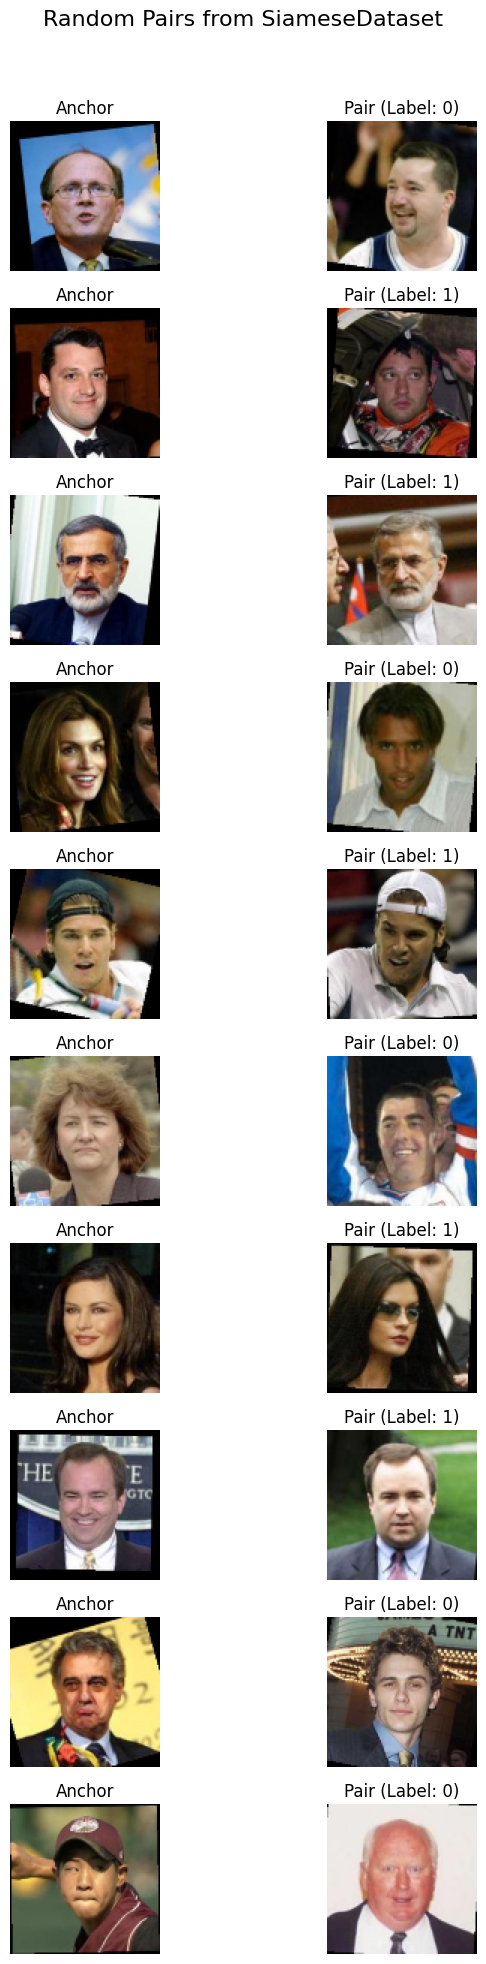

Số lượng mini-batches: 1145
Kích thước của tập train: 18320
Kích thước của tập dataset: 26172
Kích thước của tập positive: 13086
Kích thước của tập negative: 13086


In [ ]:
## 3.2 Loading and Processing the CeleA Dataset
import os
import random
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 3.1 Group Images by Identity and Create Pairs
def create_celeba_pairs(celeba_path, identity_file, max_pairs_per_person=190, target_positive_pairs=100000):
    """
    Nhóm ảnh theo danh tính và tạo cặp positive/negative từ CelebA.
    Args:
        celeba_path: Đường dẫn đến thư mục chứa ảnh (img_align_celeba).
        identity_file: Đường dẫn đến Identity_CelebA.txt.
        max_pairs_per_person: Số cặp positive tối đa cho mỗi danh tính.
        target_positive_pairs: Số cặp positive mong muốn (default: 100,000).
    Returns:
        positive_pairs: List các tuple (anchor_path, positive_path, 1).
        negative_pairs: List các tuple (anchor_path, negative_path, 0).
    """
    # Nhóm ảnh theo danh tính từ Identity_CelebA.txt
    people = defaultdict(list)
    with open(identity_file, 'r') as f:
        for line in f:
            filename, identity = line.strip().split()
            image_path = os.path.join(celeba_path, filename)
            if os.path.exists(image_path):
                people[identity].append(image_path)
            else:
                print(f"Ảnh không tồn tại: {image_path}")

    positive_pairs = []
    negative_pairs = []
    all_people = list(people.keys())

    # Tạo cặp positive
    for identity, images in people.items():
        if len(images) >= 2:  # Chỉ lấy danh tính có ít nhất 2 ảnh
            pairs = [(images[i], images[j], 1) for i in range(len(images))
                     for j in range(i + 1, len(images))]
            if len(pairs) > max_pairs_per_person:
                pairs = random.sample(pairs, max_pairs_per_person)
            positive_pairs.extend(pairs)
        if len(positive_pairs) >= target_positive_pairs:
            positive_pairs = positive_pairs[:target_positive_pairs]
            break

    # Tạo cặp negative
    num_positive = len(positive_pairs)
    while len(negative_pairs) < num_positive:
        identity = random.choice(all_people)
        if len(people[identity]) < 1:
            continue
        anchor = random.choice(people[identity])
        other_identity = random.choice(all_people)
        while other_identity == identity:
            other_identity = random.choice(all_people)
        negative_image = random.choice(people[other_identity])
        negative_pairs.append((anchor, negative_image, 0))

    return positive_pairs, negative_pairs

# Đường dẫn
celeba_path = "/kaggle/input/cele-a-dataset/Cele_A_Dataset/img_align_celeba/img_align_celeba"  
identity_file = "/kaggle/input/cele-a-dataset/Cele_A_Dataset/identity_CelebA.txt"

# Tạo cặp
positive_pairs, negative_pairs = create_celeba_pairs(
    celeba_path,
    identity_file,
    max_pairs_per_person=190,
    target_positive_pairs=120000
)

# Kết hợp và xáo trộn dữ liệu
dataset_pairs = positive_pairs + negative_pairs
random.shuffle(dataset_pairs)

# Định nghĩa augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Lật ngang với xác suất 50%
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Thay đổi sáng, tương phản
    transforms.RandomRotation(10),  # Xoay ngẫu nhiên ±10 độ
    transforms.ToTensor(),  # Chuyển sang tensor [C, H, W]
])

# 3.2 Preprocessing - Scale and Resize with Augmentation
def preprocess(file_path):
    """
    Tiền xử lý ảnh: đọc, chuyển RGB, resize, áp dụng augmentation, scale.
    """
    img = cv2.imread(file_path)
    if img is None:
        print(f"Không thể đọc ảnh: {file_path}")
        return torch.zeros((3, 100, 100))  # Trả về tensor mặc định nếu lỗi
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    img = Image.fromarray(img)  # Chuyển sang PIL Image để dùng transforms
    img = transform(img)  # Áp dụng augmentation
    return img  # Đã ở định dạng [C, H, W]

# 3.3 Create Labelled Dataset
class SiameseDataset(Dataset):
    """
    Dataset cho mô hình Siamese, sử dụng danh sách cặp (anchor, pair, label).
    """
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        anchor_path, pair_path, label = self.pairs[index]
        anchor = preprocess(anchor_path)  # [C, H, W]
        pair = preprocess(pair_path)      # [C, H, W]
        return anchor, pair, torch.tensor(label, dtype=torch.float32)

# Tạo dataset
dataset = SiameseDataset(dataset_pairs)

# 3.4 Build Train and Test Partition
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# 3.5 Display Random Pairs
def display_random_pairs(dataset, num_pairs=10):
    """
    Hiển thị ngẫu nhiên các cặp ảnh từ dataset.
    """
    indices = random.sample(range(len(dataset)), num_pairs)
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, num_pairs * 2))
    fig.suptitle('Random Pairs from CelebA SiameseDataset', fontsize=16)
    
    for i, idx in enumerate(indices):
        anchor, pair, label = dataset[idx]
        anchor_np = anchor.permute(1, 2, 0).numpy()
        pair_np = pair.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(anchor_np)
        axes[i, 0].set_title('Anchor')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pair_np)
        axes[i, 1].set_title(f'Pair (Label: {label.item():.0f})')
        axes[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Gọi hàm để hiển thị 10 cặp ảnh ngẫu nhiên
display_random_pairs(train_dataset, num_pairs=10)

# In thông tin
print(f"Số lượng mini-batches train: {len(train_loader)}")
print(f"Kích thước của tập train: {len(train_loader.dataset)}")
print(f"Kích thước của tập dataset: {len(dataset)}")
print(f"Kích thước của tập positive: {len(positive_pairs)}")
print(f"Kích thước của tập negative: {len(negative_pairs)}")

print("Successfullll !!!!")

In [ ]:
## 4. Model Engineering
# 4.1 Build Embedding Layer
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=10) 
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)  # Thêm ceil_mode=True làm cho kích thước đầu ra được làm tròn lên (ceil) thay vì làm tròn xuống (floor), tương tự với padding='same' trong TensorFlow.
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.2)  # Thêm sau conv
        self.dropout2 = nn.Dropout(0.3)  # Giảm từ 0.5
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.dropout1(x)  # Áp dụng sau conv
        x = self.flatten(x)
        x = self.dropout2(x)  # Áp dụng dropout tránh overfitting
        x = self.sigmoid(self.fc1(x))
        return x

embedding_net = EmbeddingNet()

# 4.2 Build Distance Layer L1
class L1Dist(nn.Module):
    def __init__(self):
        super(L1Dist, self).__init__()
    
    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)  # Trả về vector chênh lệch tuyệt đối giữa 2 embedding

# 4.3 Make Siamese Network 
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.L1_dist = L1Dist()
        self.fc = nn.Linear(4096, 1) # Fully connected layer to output a single value
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_img, validation_img):
        input_embedding = self.embedding_net(input_img)
        validation_embedding = self.embedding_net(validation_img)
        distances = self.L1_dist(input_embedding, validation_embedding)
        fully_connected = self.fc(distances)
        output = self.sigmoid(fully_connected)
        return output

siamese_model = SiameseNetwork(embedding_net)
print(siamese_model)

print("Successful")

SiameseNetwork(
  (embedding_net): EmbeddingNet(
    (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (L1_dist): L1Dist()
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
## 5. Training the Model

# 5.1 Establish Checkpoints
checkpoint_dir = '/kaggle/working/training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 5.2 Build Training Loop 
def print_train_time(start, end):
    total_time = end - start
    print(f"Training Time: {total_time:.2f} seconds")
    return total_time

def train_model(model, train_dataloader, test_dataloader, epochs, learning_rate, checkpoint_path=None):
    torch.manual_seed(42)
    train_time_start = timer()

    # Thiết lập device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

    # Tải checkpoint nếu có
    start_epoch = 0
    if checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Tiếp tục từ epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        print(f"Epoch {epoch + 1}\n------------------------------")
        
        ### Training
        train_loss = 0
        train_labels = []
        train_preds = []
        model.train()
        
        for batch, (input_img, validation_img, label) in enumerate(train_dataloader):
            input_img, validation_img, label = input_img.to(device), validation_img.to(device), label.to(device)
            label = label.unsqueeze(1)

            output = model(input_img, validation_img)
            loss = loss_fn(output, label)
            train_loss += loss.item()

            pred = (output > 0.5).float().cpu().numpy()
            train_preds.extend(pred.flatten())
            train_labels.extend(label.cpu().numpy().flatten())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 400 == 0:
                print(f"Looked at {batch * 16}/{len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)
        train_precision = precision_score(train_labels, train_preds, zero_division=0)
        train_recall = recall_score(train_labels, train_preds, zero_division=0)
        print(f"Train Loss: {train_loss:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

        ### Testing
        test_loss = 0
        test_labels = []
        test_preds = []
        model.eval()
        with torch.inference_mode():
            for input_img, validation_img, label in test_dataloader:
                input_img, validation_img, label = input_img.to(device), validation_img.to(device), label.to(device)
                label = label.unsqueeze(1)
                test_output = model(input_img, validation_img)
                test_loss += loss_fn(test_output, label).item()

                pred = (test_output > 0.5).float().cpu().numpy()
                test_preds.extend(pred.flatten())
                test_labels.extend(label.cpu().numpy().flatten())

        test_loss /= len(test_dataloader)
        test_precision = precision_score(test_labels, test_preds, zero_division=0)
        test_recall = recall_score(test_labels, test_preds, zero_division=0)
        print(f"Test Loss: {test_loss:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

        # Lưu checkpoint
        checkpoint_path_save = os.path.join(checkpoint_dir, f'ckpt_epoch_{epoch + 1}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
        }, checkpoint_path_save)
        print(f"Đã lưu checkpoint tại: {checkpoint_path_save}")

    train_time_end = timer()
    print_train_time(train_time_start, train_time_end)

print("Successful !")

Successful !


In [ ]:
### 6. Chạy huấn luyện
# Để train từ đầu:
train_model(siamese_model, train_loader, test_loader, epochs=30, learning_rate=0.0001)

# Để tiếp tục từ checkpoint (ví dụ từ epoch cụ thể):
# checkpoint_to_load = '/kaggle/input/siamese-face-recognition-model/training_checkpoints/ckpt_epoch_30.pt'
# train_model(siamese_model, train_loader, test_loader, epochs=45, learning_rate=0.0001, checkpoint_path=checkpoint_to_load)

print("Successful !")

In [ ]:
### 7. Inference
import torch
import torch.nn as nn
import cv2
import os
import numpy as np
from collections import defaultdict
import time
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN
from PIL import Image

# Định nghĩa mô hình
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dropout2(x)
        x = self.sigmoid(self.fc1(x))
        return x

class L1Dist(nn.Module):
    def __init__(self):
        super(L1Dist, self).__init__()

    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.L1_dist = L1Dist()
        self.fc = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_img, validation_img):
        input_embedding = self.embedding_net(input_img)
        validation_embedding = self.embedding_net(validation_img)
        distances = self.L1_dist(input_embedding, validation_embedding)
        fully_connected = self.fc(distances)
        output = self.sigmoid(fully_connected)
        return output

# Khởi tạo device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(image_size=100, margin=20, device=device)

transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển sang tensor và chuẩn hóa [0, 1]
])

def img_preprocess(frame):
    # Kiểm tra frame có hợp lệ không
    if frame is None or frame.size == 0:
        print("Frame không hợp lệ")
        return None, None

    # Lấy kích thước frame
    h, w = frame.shape[:2]
    print(f"Frame shape: {frame.shape}")  # Debug kích thước frame

    # Phát hiện khuôn mặt
    boxes, _ = mtcnn.detect(frame)
    if boxes is None:
        print("Không tìm thấy khuôn mặt")
        return None, None

    x1, y1, x2, y2 = boxes[0].astype(int)
    print(f"Tọa độ MTCNN: x1={x1}, y1={y1}, x2={x2}, y2={y2}")  # Debug tọa độ

    # Kiểm tra tọa độ hợp lệ
    if x1 >= x2 or y1 >= y2:
        print(f"Tọa độ không hợp lệ: x1={x1}, x2={x2}, y1={y1}, y2={y2}")
        return None, None

    # Đảm bảo tọa độ nằm trong kích thước frame
    x1, x2 = max(0, x1), min(w, x2)
    y1, y2 = max(0, y1), min(h, y2)
    if x1 >= x2 or y1 >= y2:
        print(f"Tọa độ sau điều chỉnh không hợp lệ: x1={x1}, x2={x2}, y1={y1}, y2={y2}")
        return None, None

    # Kiểm tra kích thước vùng crop
    crop_width = x2 - x1
    crop_height = y2 - y1
    if crop_width < 10 or crop_height < 10:  # Đảm bảo vùng crop có kích thước tối thiểu
        print(f"Vùng crop quá nhỏ: width={crop_width}, height={crop_height}")
        return None, None

    face = frame[y1:y2, x1:x2]
    # Kiểm tra face có hợp lệ không
    if face is None or face.size == 0 or face.shape[0] == 0 or face.shape[1] == 0:
        print("Vùng khuôn mặt rỗng sau khi crop")
        return None, None

    # Resize lại ảnh khuôn mặt về 100x100
    face = cv2.resize(face, (100, 100))
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_pil = Image.fromarray(face_rgb)
    face_tensor = transform(face_pil)
    print(f"Shape after transform: {face_tensor.shape}")  # Kiểm tra shape
    # Chuyển lại ảnh RGB về BGR để hiển thị bằng OpenCV
    face_display = cv2.cvtColor(face_rgb, cv2.COLOR_RGB2BGR)
    return face_tensor.unsqueeze(0).to(device), face_display

# Tải mô hình
model_path = 'training_checkpoints\\ckpt_epoch_43.pt'
checkpoint = torch.load(model_path, map_location=device)
print("Epoch của checkpoint:", checkpoint['epoch'])
print("Train Loss của checkpoint:", checkpoint['train_loss'])
print("Test Loss của checkpoint:", checkpoint['test_loss'])
embedding_net = EmbeddingNet()
siamese_model = SiameseNetwork(embedding_net).to(device)
checkpoint = torch.load(model_path, map_location=device)
siamese_model.load_state_dict(checkpoint['model_state_dict'])
siamese_model.eval()
print("Một số trọng số của conv1:", siamese_model.embedding_net.conv1.weight[0, 0, :3, :3])

# Tiền xử lý anchor database (chỉ lấy một ảnh đầu tiên cho mỗi identity)
anchor_database_path = 'data\\anchor_database_onehot'
anchor_imgs = {}
anchor_filenames = {}
for identity in os.listdir(anchor_database_path):
    identity_path = os.path.join(anchor_database_path, identity)
    if os.path.isdir(identity_path):
        anchor_imgs[identity] = []
        anchor_filenames[identity] = []
        # Chỉ lấy ảnh đầu tiên
        anchor_file = os.listdir(identity_path)[0] if os.listdir(identity_path) else None
        if anchor_file and anchor_file.endswith(('.jpg', '.jpeg', '.png')):
            anchor_path = os.path.join(identity_path, anchor_file)
            img = cv2.imread(anchor_path)
            if img is None:
                print(f"Không thể đọc ảnh: {anchor_path}")
                continue
            img_tensor, _ = img_preprocess(img)  # Chỉ lấy tensor
            if img_tensor is not None:
                anchor_imgs[identity].append(img_tensor)
                anchor_filenames[identity].append(anchor_file)

if not any(anchor_imgs.values()):
    raise ValueError("Không có ảnh anchor hợp lệ trong database")

# Mở webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise ValueError("Không thể mở webcam.")

# Kiểm tra kích thước khung hình webcam
ret, frame = cap.read()
if ret:
    print(f"Kích thước khung hình webcam: {frame.shape}")
    if frame.shape[0] < 370 or frame.shape[1] < 450:  # Kiểm tra kích thước tối thiểu
        print("Cảnh báo: Kích thước khung hình webcam quá nhỏ, có thể gây lỗi crop.")
else:
    print("Không thể đọc khung hình từ webcam")

threshold = 0.7  # Ngưỡng
result_label = "Press Space to capture"
result_prob = 0.0
result_identity = ""
result_color = (255, 255, 255)
processed_img = None  # Biến để lưu ảnh đã xử lý

debug_dir = 'application_data/input_image'
os.makedirs(debug_dir, exist_ok=True)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Không thể đọc khung hình từ webcam")
        break

    # Kiểm tra kích thước frame trước khi crop
    if frame.shape[0] < 370 or frame.shape[1] < 450:
        print("Khung hình quá nhỏ để crop: ", frame.shape)
        continue

    frame = frame[120:120+250, 200:200+250, :]
    cv2.putText(frame, f"{result_label} ({result_prob:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, result_color, 2)
    if result_identity:
        cv2.putText(frame, f"Identity: {result_identity}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, result_color, 2)

    cv2.imshow('Face Verification', frame)

    # Hiển thị ảnh đã xử lý nếu có
    if processed_img is not None:
        cv2.imshow('Processed Face', processed_img)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord(' '):
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        debug_path = os.path.join(debug_dir, f'webcam_capture_{timestamp}.jpg')
        cv2.imwrite(debug_path, frame)

        webcam_img, processed_img = img_preprocess(frame)
        if webcam_img is None:
            result_label = "No face detected"
            result_prob = 0.0
            result_identity = ""
            result_color = (0, 0, 255)
            processed_img = None  # Reset ảnh nếu không tìm thấy khuôn mặt
            continue

        best_identity = None
        best_prob = 0.0

        for identity, anchor_list in anchor_imgs.items():
            if not anchor_list:
                continue
            anchor_img = anchor_list[0]  # Chỉ có một ảnh
            webcam_batch = webcam_img
            with torch.no_grad():
                output = siamese_model(anchor_img, webcam_batch)
                prob = output.squeeze().cpu().item()
            
            if prob > best_prob:
                best_prob = prob
                best_identity = identity

        if best_prob > threshold:
            result_label = "Valid Face"
            result_prob = best_prob
            result_identity = best_identity
            result_color = (0, 255, 0)
        else:
            result_label = "Invalid Face"
            result_prob = best_prob
            result_identity = ""
            result_color = (0, 0, 255)
        

cap.release()
cv2.destroyAllWindows()

c:\Users\Gia Hung\anaconda3\envs\smart_home_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch của checkpoint: 42
Train Loss của checkpoint: 0.23478831054472055
Test Loss của checkpoint: 0.24790372461701432
Một số trọng số của conv1: tensor([[0.0650, 0.0823, 0.0787],
        [0.0632, 0.0898, 0.0985],
        [0.0491, 0.0703, 0.0939]], grad_fn=<SliceBackward0>)
Frame shape: (250, 250, 3)
Tọa độ MTCNN: x1=36, y1=47, x2=182, y2=242
Shape after transform: torch.Size([3, 100, 100])
Kích thước khung hình webcam: (480, 640, 3)
Frame shape: (250, 250, 3)
Tọa độ MTCNN: x1=30, y1=67, x2=169, y2=242
Shape after transform: torch.Size([3, 100, 100])
Frame shape: (250, 250, 3)
Tọa độ MTCNN: x1=31, y1=69, x2=170, y2=244
Shape after transform: torch.Size([3, 100, 100])
Frame shape: (250, 250, 3)
Tọa độ MTCNN: x1=36, y1=67, x2=174, y2=237
Shape after transform: torch.Size([3, 100, 100])
Frame shape: (250, 250, 3)
Tọa độ MTCNN: x1=40, y1=65, x2=178, y2=237
Shape after transform: torch.Size([3, 100, 100])
Frame shape: (250, 250, 3)
Tọa độ MTCNN: x1=20, y1=71, x2=155, y2=246
Shape after trans